# <center> Can Oversampling imbalanced data improve model's performance?</center>

You might have encountered the phrase "Imbalanced data" since you started your journy with data science. When do we call data "imbalanced"?.

Well, If your boss gave you a dataset to complete a particular classification task, you would first look for the target/dependent/class variable which is always categorical in such cases. If the target variable has two levels, you are then in charge of building a binary classification model. If the there are more than two classes in the target variable, the problem becomes a multiclass classification one. For the sake of simplicity, I will use a binary classification problem- The bank loan. The dataset consists of 614 examples/records/customers who have a pllied for a bank loan. 13 features/predictors/independent variables were extracted from each customer and the loan status was given as a target variable with two levels/classes: "yes" when the loan was granted and "No" when the application was rejected. 

In [1]:
clear all

In [2]:
# Import import required packages

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

In [3]:
# Read CSV file into a dataframe
df=pd.read_csv('dataset/train.csv')

In [4]:
df.shape   # The dataset consists of 614 records/examples, which makes it a small  one

(614, 13)

In [5]:
# Let us view the first 5 rows/records of the data
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Let us heck the data types of the predictors. Note that the columns of type object refers to categorical predictors while others of type int 64 and float 64 are numerical predictors

In [6]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

## Class distribution

The target/dependent variable is Loan_Status. its distribution is plotted below as piechart

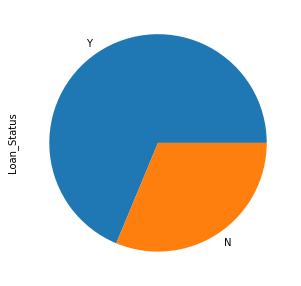

In [7]:
df['Loan_Status'].value_counts().plot.pie(y='Loan_Status',figsize=(5, 5))

The figure above shows that the number of customers with rejected application is much less (less than a half) than the number of custormers with  granted loan, which means that the data is imbalanced.
What about making the data balanced by duplicating the minority class examples i.e, using random oversampling? Shall we upsample our data now? 

No because firstly, we need to clean the data and secondly, upsampling the data before splitting it into training and validation sets would cause data leakage (see SMOTE() below)  

In [10]:
# Counting missing values for each columns
df.isnull().sum(axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### The total number of missing values

In [11]:
df.isnull().sum(axis=0).sum()

149

There several methods which are commonly used to handle missing values in a dataset. At the moment, we will use the simplest one which removes the records/rows with null values from the data. Other methods will be presented and used in the next notebooks.

Can we drop rows with missing values before splitting dataset into training and validation folds? 

Yes, we can as this would not lead to data leakage. 

In [12]:
df=df.dropna()  

In [13]:
df.shape

(480, 13)

The number of rows, after rows with missing values are removed, is equal to 480 which is greater than (614-149). This is because some rows have more than one missing values. 

#### Remove the 'Loan_ID' column
The loan_Id predictor is uninformative predictor so it will removed. 

In [14]:
df=df.drop('Loan_ID', axis=1)

The dataframe of indepoendent variables/predictors can be created by removing the dependent variable

In [15]:
X=df.drop('Loan_Status', axis=1)

In [16]:
# Convert all numerical predictors into float43
def convert_float64(x):
    return x.astype(np.float64)

 ### Feature Preprocessing 
 
Some numerical features with a large scale may have a sort of domination during the stage of model training, which has an impact on the optiml model's parameters in the end. t
Therefor, transforming predictoors into a new form can reduce such imapch and lead to a better model performance. 

Preprocessing functions are predictor-datatype dependent. For instance, methods applied to numerical predictors are differemt from those used for categorical features. Take a numerical predictor for example, StandardScaler()makes it zero-centred and scaled to unit variance.   

Can we apply precessing functions to the whole data i.e before splitting? 
No, It should be implemented after data is splitted into training and validation folds to prevent data leaskage. 

What would happen if we preprocessed the whole data? 

If StandardScaler() is used, the mean and standard deviation should be computed first from the whole data. When data is splitted into training and validation folds, the validation subset would be scaled based on parameters computed using both training and validation data. As a result, data leakage occurs.


To tackle such a problem, the preprocessor should be built based only on training data and used to transform the validation set during cross-validation. In this tutorial,  ColumnTransformer() is used to apply appropriate pipelines to both numerical and categorical predictors/columns of the training folds. 

In [17]:
# Numerical columns
numerical_cols=X.select_dtypes(include=np.number).columns.tolist()

# Numerical p[ipeline
numerical_pipeline=make_pipeline(FunctionTransformer(func=convert_float64, validate=False),
    StandardScaler())

# Categorical columns
categorical_cols=X.select_dtypes(include='object').columns.tolist()


# Categorical pipeline
categorical_pipeline = make_pipeline(OneHotEncoder(categories='auto', drop='first'))

In [18]:
preprocessor1 = ColumnTransformer(
    [('numerical_preprocessing', numerical_pipeline, numerical_cols),
     ('categorical_preprocessing', categorical_pipeline, categorical_cols)],
     remainder='drop')


In [19]:
from imblearn.over_sampling import SMOTE 

preprocessor2=SMOTE(sampling_strategy='minority') # It will be only applied to the training folds 



In [20]:
y=df['Loan_Status']

In [21]:
y=y.replace(['Y','N'],[1,0]).astype(int)

In [22]:
y.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

# Building the model

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import initializers

def build_model(input_size):
    model=Sequential()
    
    #KI= initializers.RandomNormal(0.0,0.05)
    KI= initializers.GlorotNormal()
    BI= initializers.zeros()
    model.add(Dense(100, activation='relu', name='layer1', kernel_initializer=KI,bias_initializer=BI,input_dim=input_size))
    
    #model.add(BatchNormalization())

    model.add(Dense(200, activation='relu', name='layer2', kernel_initializer=KI,bias_initializer=BI))

    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))

    model.add(Dense(10, activation='relu', name='layer3', kernel_initializer=KI,bias_initializer=BI))

    model.add(Dense(1,name='layer4', kernel_initializer=KI,bias_initializer=BI))
    # 1- Categorical Classification: The number of neurons in the output layer is exactly the same as the number of classes (2,..)
    # the Softmax function is used to conver logits to probability

    #loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # 2- Binary Classification: The output layer has only one neuron 
    # and the Sigmoid function is used to conver logits to probability
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True) 
    model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
    return model
 

To ensure that the target variable of each batch extracted from the training folds is evenly distributed (balanced), BalancedBatchGenerator() is used. 

In [24]:
from sklearn.metrics import roc_auc_score
from imblearn.keras import BalancedBatchGenerator

def fit_predict(X_train, y_train, X_test, y_test):
    model = build_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train,batch_size=32)
    model.fit_generator(generator=training_generator, epochs=10, verbose=1)

    #model.fit(X_train, y_train, epochs=25, verbose=1, batch_size=32)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred)

The stratified folds are made by preserving the percentage of samples for each class as shopwn below. Bothe training and validation data are balaned. 

In [25]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

skf = StratifiedKFold(n_splits=5,  shuffle=True)

class_dist_train=[]
class_dist_test=[]

for train_idx, valid_idx in skf.split(X, y):
    X_local_train = X.iloc[train_idx]
    y_local_train = y.iloc[train_idx]
        
    X_local_test =X.iloc[valid_idx]
    y_local_test = y.iloc[valid_idx]
    class_dist_train.append(y_local_train.value_counts().tolist())
    class_dist_test.append(y_local_test.value_counts().tolist())


In [26]:
class_dist_train

[[266, 118], [266, 118], [266, 118], [265, 119], [265, 119]]

In [27]:
class_dist_test

[[66, 30], [66, 30], [66, 30], [67, 29], [67, 29]]

In [28]:

def Accuracy(X,y, upsample=True):
    Accuracy=[]
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_idx, valid_idx in skf.split(X, y):
        X_local_train = preprocessor1.fit_transform(X.iloc[train_idx])
        y_local_train = y.iloc[train_idx].values.ravel()
        if upsample:
            X_local_train ,  y_local_train =preprocessor2.fit_sample( X_local_train ,  y_local_train)
       
        X_local_test = preprocessor1.transform(X.iloc[valid_idx])
        y_local_test = y.iloc[valid_idx].values.ravel()
        
                                                
        roc_auc = fit_predict(X_local_train, y_local_train, X_local_test, y_local_test)
        Accuracy.append(roc_auc)
    return Accuracy
        
    

In [29]:
# Model training and cross validation

Accuracy_nosample=Accuracy(X,y, False) # Original data
Accuracy_upsample=Accuracy(X,y,True)   # with oversampling

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5840 - accuracy: 0.5156
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5203 - accuracy: 0.6719
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4921 - accuracy: 0.7539
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7383
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7656
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4464 - accuracy: 0.7695
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.7773
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.7734
Epoch 10/10
8/8 [==============================] - 0s 2ms/st

Epoch 1/10
8/8 [==============================] - 0s 1ms/step - loss: 0.6731 - accuracy: 0.5039
Epoch 2/10
8/8 [==============================] - 0s 1ms/step - loss: 0.6268 - accuracy: 0.5039
Epoch 3/10
8/8 [==============================] - 0s 1ms/step - loss: 0.6002 - accuracy: 0.5039
Epoch 4/10
8/8 [==============================] - 0s 1ms/step - loss: 0.5832 - accuracy: 0.5039
Epoch 5/10
8/8 [==============================] - 0s 1ms/step - loss: 0.5747 - accuracy: 0.5039
Epoch 6/10
8/8 [==============================] - 0s 1ms/step - loss: 0.5697 - accuracy: 0.5039
Epoch 7/10
8/8 [==============================] - 0s 1ms/step - loss: 0.5647 - accuracy: 0.5039
Epoch 8/10
8/8 [==============================] - 0s 1ms/step - loss: 0.5560 - accuracy: 0.5039
Epoch 9/10
8/8 [==============================] - 0s 1ms/step - loss: 0.5416 - accuracy: 0.5039
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.5213 - accuracy: 0.5117
Epoch 1/10
8/8 [=======================

18/18 [==============================] - 0s 1ms/step - loss: 0.4532 - accuracy: 0.7604
Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4350 - accuracy: 0.7778
Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4184 - accuracy: 0.8056
Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.3979 - accuracy: 0.8160
Epoch 10/10
18/18 [==============================] - 0s 1ms/step - loss: 0.3815 - accuracy: 0.8229
Epoch 1/10
18/18 [==============================] - 0s 1ms/step - loss: 0.6221 - accuracy: 0.5573
Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5319 - accuracy: 0.7083
Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5095 - accuracy: 0.6962
Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.4890 - accuracy: 0.7222
Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.4732 - accuracy: 0.7674
Epoch 6/10
18/18 [============

Epoch 1/10
18/18 [==============================] - 0s 1ms/step - loss: 0.6303 - accuracy: 0.5295
Epoch 2/10
18/18 [==============================] - 0s 1ms/step - loss: 0.5270 - accuracy: 0.7344
Epoch 3/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4912 - accuracy: 0.7431
Epoch 4/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4714 - accuracy: 0.7604
Epoch 5/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4615 - accuracy: 0.7708
Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4522 - accuracy: 0.7656
Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7899
Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4260 - accuracy: 0.7899
Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4131 - accuracy: 0.8003
Epoch 10/10
18/18 [==============================] - 0s 1ms/step - loss: 0.3968 - accuracy: 0.8108
Epoch 1/10
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.4945 - accuracy: 0.7396
Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4769 - accuracy: 0.7431
Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4617 - accuracy: 0.7708
Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4566 - accuracy: 0.7691
Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7882
Epoch 10/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4238 - accuracy: 0.7778


In [30]:
d={'Accyracy_nosample': Accuracy_nosample  , 'Accuracy_upsample':Accuracy_upsample}
df_results=pd.DataFrame(d)

In [31]:
df_results

,Accyracy_nosample,Accuracy_upsample
0,0.696970,0.787879
1,0.868687,0.751515
2,0.810101,0.725253
3,0.771717,0.670707
4,0.795960,0.864646
5,0.749495,0.692929
6,0.761616,0.715152
7,0.747475,0.753535
8,0.781513,0.640756
9,0.638655,0.852941


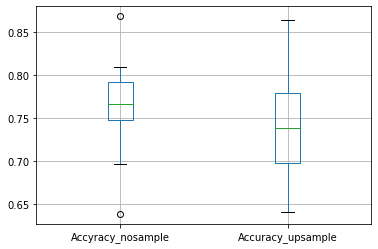

In [32]:
df_results.boxplot()

### Conclusion

The chart of validation accuracy shows that upsampling the training data has not improved the model's performance. This can be explained as a result of duplicating examples of the minority class in the training data, which made the model learn/overfit the training data well. This led to large generalization error when the model was evaluated on the unseen 
validation data. 

But wait a moment! There is something else we need to blame here for such results, which is the data size. It became even smaller after dropping rows with missing values which considerably increased the overfitting after oversampling had been applied. 